In [ ]:
# Add the path to the Utils folder
import sys
sys.path.append('../Utils')

import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.losses import Loss
from sklearn.utils.class_weight import compute_class_weight

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from tensorflow.keras.callbacks import ModelCheckpoint

from notebookUtils import visualize_class_distribution, visualize_image_pairs, evaluate_model_on_folder, visualize_example, visualize_images, resample_folder, load_data, simple_model, unet_model

# U-Net model

## Simple U-Net model

In [ ]:
# tf.config.set_visible_devices([], 'GPU')

num_classes = 5
input_size = (128, 128, 3)
batch_size = 1  # You can adjust this based on your available memory
epochs = 20
train_sat_folder = "./../Data_resampled_128/train/sat/"
train_gt_folder = "./../Data_resampled_128/train/gt/"

val_sat_folder = "./../Data_resampled_128/validate/sat/"
val_gt_folder = "./../Data_resampled_128/validate/gt/"

# Function to load and preprocess the dataset
def load_data(sat_folder, gt_folder, batch_size=batch_size):
    input_images = []
    output_masks = []

    filenames = [filename for filename in os.listdir(sat_folder) if filename.endswith(".tif")]
    num_batches = len(filenames) // batch_size

    for batch_idx in tqdm(range(num_batches), desc="Loading batches", unit="batch"):
        batch_filenames = filenames[batch_idx * batch_size : (batch_idx + 1) * batch_size]
        
        batch_inputs = []
        batch_outputs = []
        for filename in batch_filenames:
            input_path = os.path.join(sat_folder, filename)
            output_path = os.path.join(gt_folder, filename.replace("sat_", "gt_"))

            # Load and preprocess input image
            input_image = np.array(Image.open(input_path)) / 255.0  # Normalize to [0, 1]
            batch_inputs.append(input_image)

            # Load and preprocess output mask
            output_mask = np.array(Image.open(output_path))

            # Ensure that class indices are within the range [0, num_classes-1]
            output_mask = np.clip(output_mask, 0, num_classes - 1)
            output_mask = keras.utils.to_categorical(output_mask, num_classes=num_classes)
            batch_outputs.append(output_mask)

        input_images.append(np.array(batch_inputs))
        output_masks.append(np.array(batch_outputs))

    return np.vstack(input_images), np.vstack(output_masks)

# Load and preprocess the training dataset
X_train, y_train = load_data(train_sat_folder, train_gt_folder)

# Load and preprocess the validation dataset
X_val, y_val = load_data(val_sat_folder, val_gt_folder)

def double_conv_block(x, n_filters):
   # Conv2D then ReLU activation
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   # Conv2D then ReLU activation
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   return x

def downsample_block(x, n_filters):
   f = double_conv_block(x, n_filters)
   p = layers.MaxPool2D(2)(f)
   p = layers.Dropout(0.3)(p)
   return f, p

def upsample_block(x, conv_features, n_filters):
   # upsample
   x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
   # concatenate
   x = layers.concatenate([x, conv_features])
   # dropout
   x = layers.Dropout(0.3)(x)
   # Conv2D twice with ReLU activation
   x = double_conv_block(x, n_filters)
   return x

# Define U-Net model for 5 classes
def unet_model(input_size=(128, 128, 3), num_classes=5):
    inputs = keras.Input(input_size)
    
    # encoder: contracting path - downsample
    # 1 - downsample
    f1, p1 = downsample_block(inputs, 64)
    # 2 - downsample
    f2, p2 = downsample_block(p1, 128)
    # 3 - downsample
    f3, p3 = downsample_block(p2, 256)
    # 4 - downsample
    f4, p4 = downsample_block(p3, 512)
    # 5 - bottleneck
    bottleneck = double_conv_block(p4, 1024)
    # decoder: expanding path - upsample
    # 6 - upsample
    u6 = upsample_block(bottleneck, f4, 512)
    # 7 - upsample
    u7 = upsample_block(u6, f3, 256)
    # 8 - upsample
    u8 = upsample_block(u7, f2, 128)
    # 9 - upsample
    u9 = upsample_block(u8, f1, 64)
    # outputs
    outputs = layers.Conv2D(num_classes, 1, padding="same", activation = "softmax")(u9)
    # unet model with Keras Functional API
    unet_model = tf.keras.Model(inputs, outputs, name="U-Net")
    return unet_model

# Assuming class labels are integers starting from 0
class_labels = [0, 1, 2, 3, 4]

# Class distribution in your dataset
class_distribution = [0.59, 0.32, 0.06, 0.02, 0.01]

class_weight = {0: .59, 1: .32, 2: .06, 3: .02, 4: .01}

METRICS = [
      keras.metrics.BinaryCrossentropy(name='cross entropy'),
      keras.metrics.CategoricalCrossentropy(name='cat_cross_entropy'),
      keras.metrics.MeanIoU(name='mIoU', num_classes=num_classes),
      keras.metrics.MeanSquaredError(name='Brier score'),
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

# Initialize and compile the model
model_unet_noClassWeights = unet_model(num_classes=num_classes)
model_unet_noClassWeights.compile(optimizer="adam", loss="categorical_crossentropy", metrics=METRICS)

# Define the ModelCheckpoint callback
checkpoint = ModelCheckpoint(
    'improved_model_{epoch:02d}_{val_accuracy:.3f}.keras',
    monitor='val_accuracy',  # Monitor validation accuracy
    save_best_only=True,
    save_weights_only=False,  # Save entire model
    mode='max',  # Save the model with the highest validation accuracy
    verbose=1
)

# Train the model with class weights and checkpoint callback
model_unet_history_noClassWeights = model_unet_noClassWeights.fit(X_train, y_train,
                          epochs=epochs,
                          batch_size=batch_size,
                          validation_data=(X_val, y_val),
                          #class_weight=class_weight,
                          callbacks=[checkpoint]
)

Loading batches: 100%|██████████| 1224/1224 [00:03<00:00, 315.79batch/s]


Epoch 1/20
7938/7938 [==============================] - ETA: 0s - loss: 1.0398 - cross entropy: 0.6376 - cat_cross_entropy: 1.0398 - mIoU: 0.4000 - Brier score: 0.0883 - tp: 80302712.0000 - fp: 30992008.0000 - tn: 489232640.0000 - fn: 49753504.0000 - accuracy: 0.8758 - precision: 0.7215 - recall: 0.6174 - auc: 0.9123 - prc: 0.7347
Epoch 1: val_accuracy improved from -inf to 0.92027, saving model to improved_model_01_0.920.keras
7938/7938 [==============================] - 6413s 807ms/step - loss: 1.0398 - cross entropy: 0.6376 - cat_cross_entropy: 1.0398 - mIoU: 0.4000 - Brier score: 0.0883 - tp: 80302712.0000 - fp: 30992008.0000 - tn: 489232640.0000 - fn: 49753504.0000 - accuracy: 0.8758 - precision: 0.7215 - recall: 0.6174 - auc: 0.9123 - prc: 0.7347 - val_loss: 0.5979 - val_cross entropy: 0.4662 - val_cat_cross_entropy: 0.5979 - val_mIoU: 0.4000 - val_Brier score: 0.0582 - val_tp: 15805934.0000 - val_fp: 3746607.0000 - val_tn: 76469536.0000 - val_fn: 4248082.0000 - val_accuracy: 0.9

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d_19 (Conv2D)          (None, 128, 128, 64)         1792      ['input_2[0][0]']             
                                                                                                  
 conv2d_20 (Conv2D)          (None, 128, 128, 64)         36928     ['conv2d_19[0][0]']           
                                                                                                  
 max_pooling2d_4 (MaxPoolin  (None, 64, 64, 64)           0         ['conv2d_20[0][0]']           
 g2D)                                                                                         

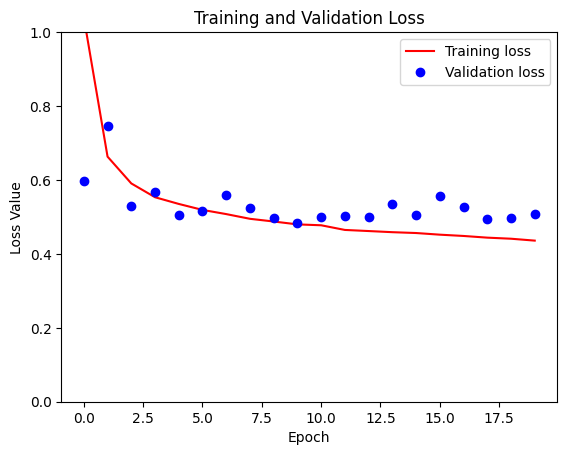

In [ ]:
model_unet_noClassWeights.summary()

loss = model_unet_history_noClassWeights.history['loss']
val_loss = model_unet_history_noClassWeights.history['val_loss']

plt.figure()
plt.plot(model_unet_history_noClassWeights.epoch, loss, 'r', label='Training loss')
plt.plot(model_unet_history_noClassWeights.epoch, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

### Simple U-Net model - Architecture

In [ ]:
model_unet_noClassWeights.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 128, 128, 64)         36928     ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 64, 64, 64)           0         ['conv2d_1[0][0]']            
 D)                                                                                           

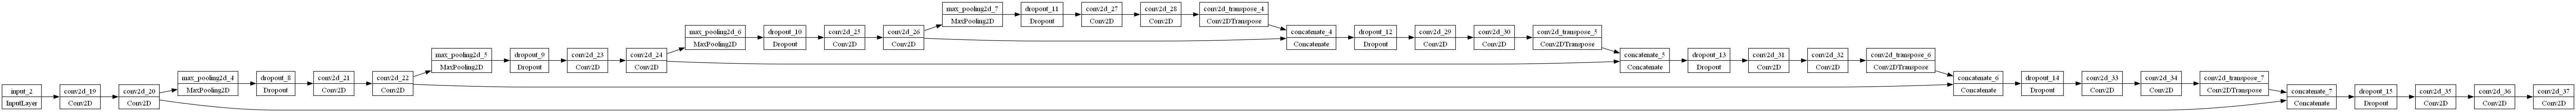

In [ ]:
keras.utils.plot_model(
    model_unet_noClassWeights,
    to_file="model_unet.png",
    #show_shapes=True,
    #show_dtype=True,
    #show_layer_names=True,
    rankdir="LR",  # horizontal layout
    #rankdir="TB", # vertical layout
    #expand_nested=False,
    #dpi=200,
    #show_layer_activations=True,
    #show_trainable=True
)

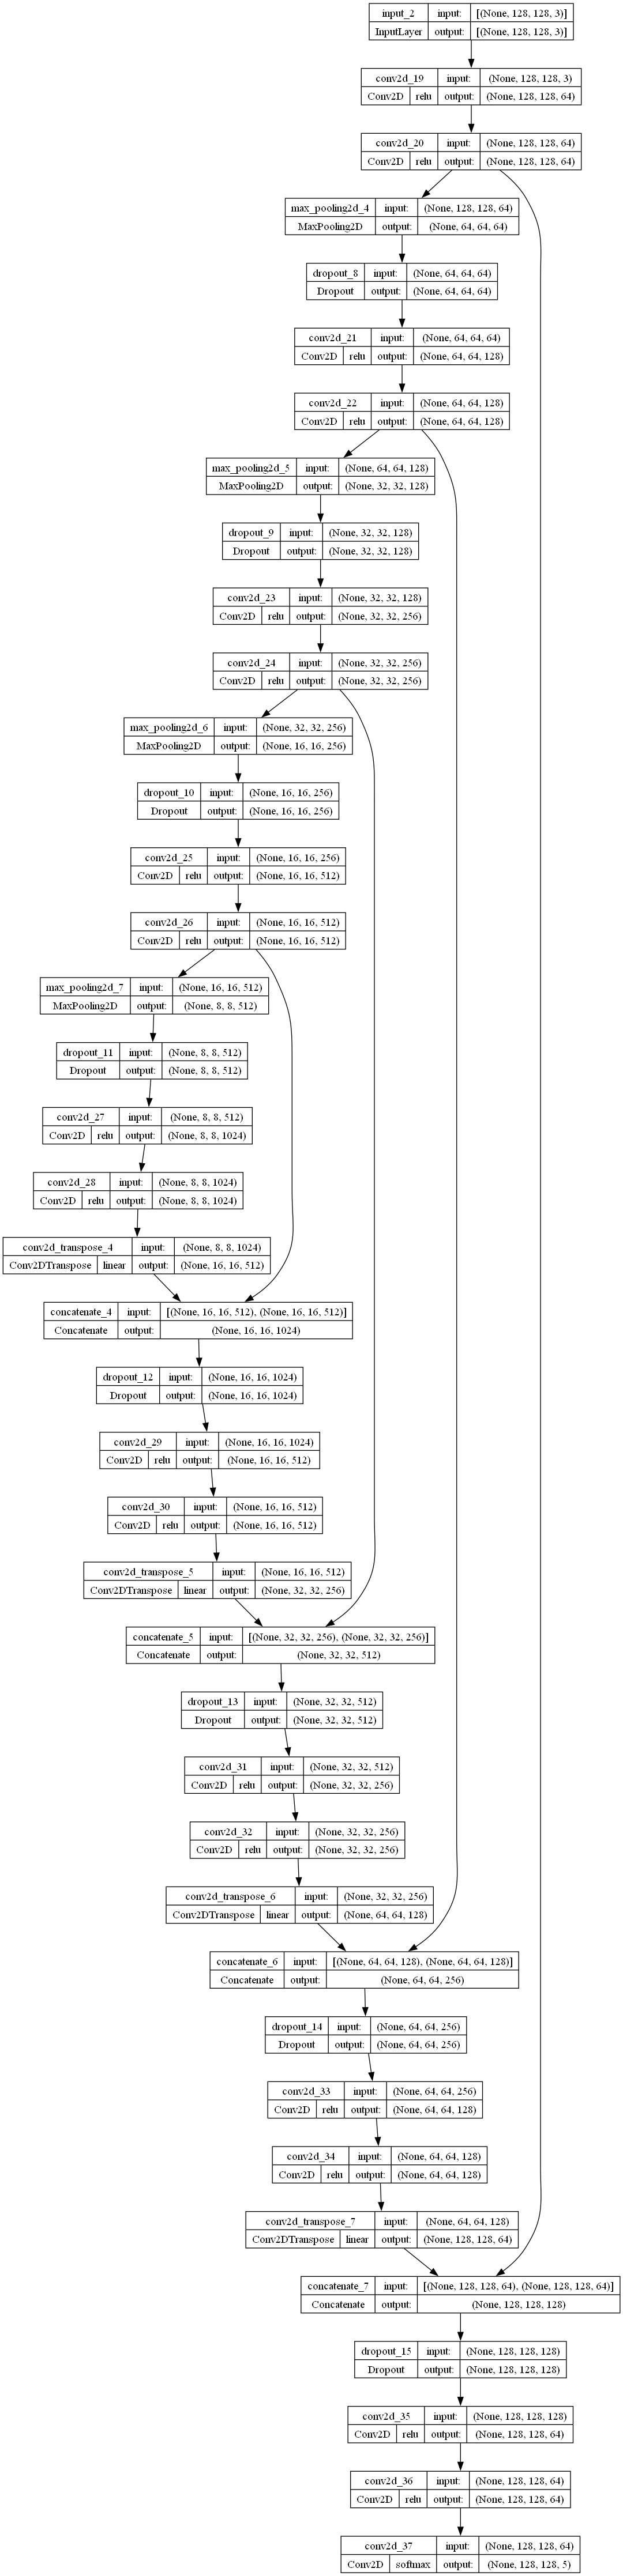

In [ ]:
keras.utils.plot_model(
    model_unet_noClassWeights,
    to_file="model_unet.png",
    show_shapes=True,
    #show_dtype=True,
    show_layer_names=True,
    #rankdir="LR",  # horizontal layout
    rankdir="TB", # vertical layout
    #expand_nested=False,
    #dpi=200,
    show_layer_activations=True,
    #show_trainable=True
)

### Simple U-Net model - Validation

1/1 [==============================] - 0s 402ms/step


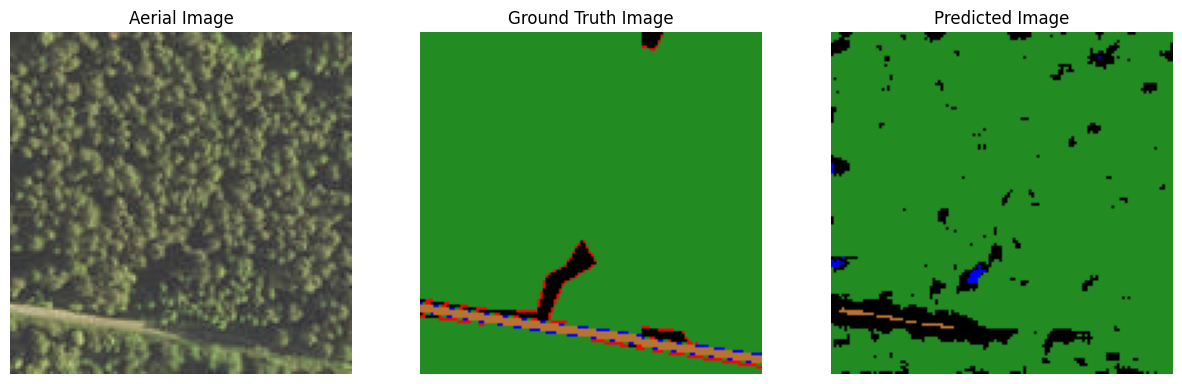

1/1 [==============================] - 0s 464ms/step


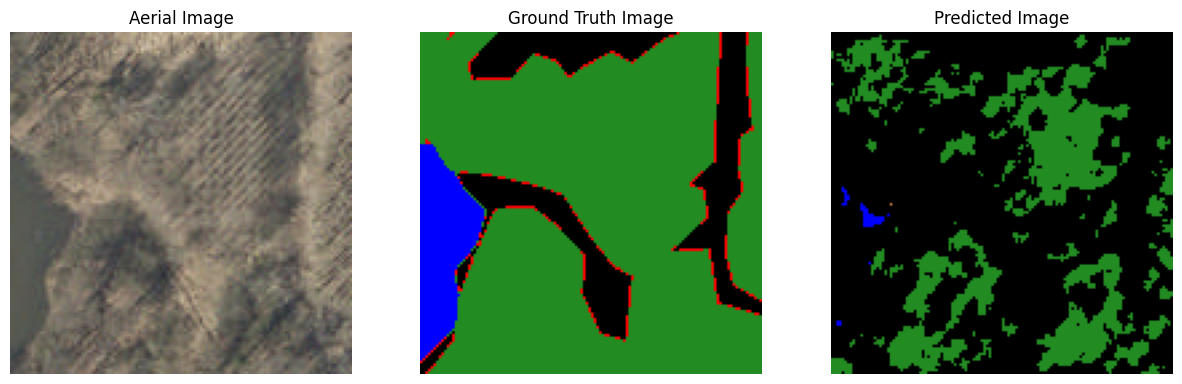

1/1 [==============================] - 0s 422ms/step


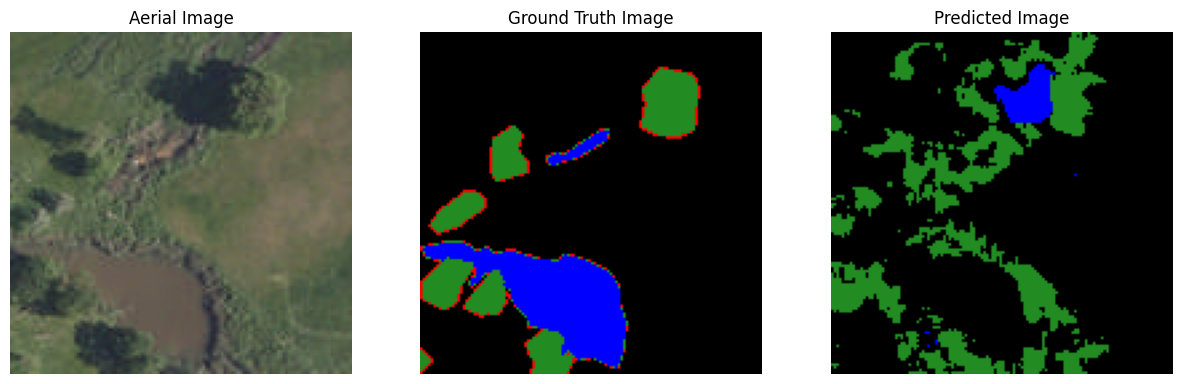

1/1 [==============================] - 0s 443ms/step


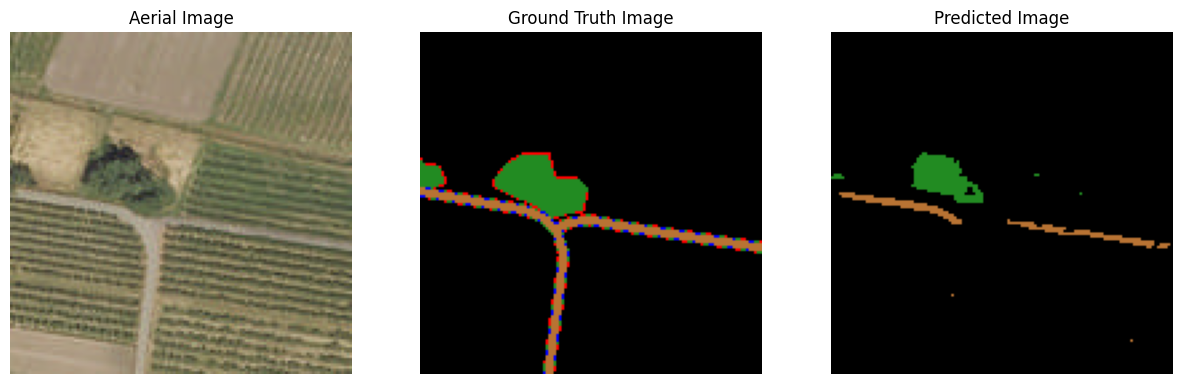

1/1 [==============================] - 0s 434ms/step


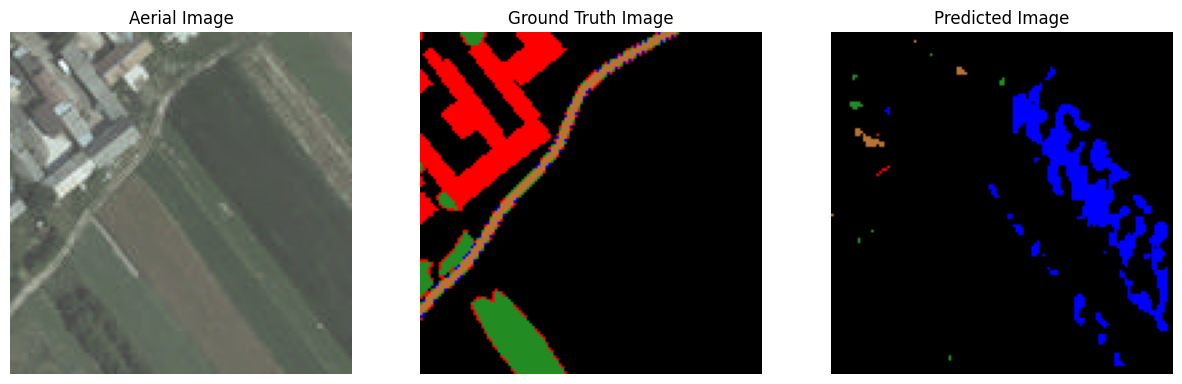

249/249 [==============================] - 861s 3s/step


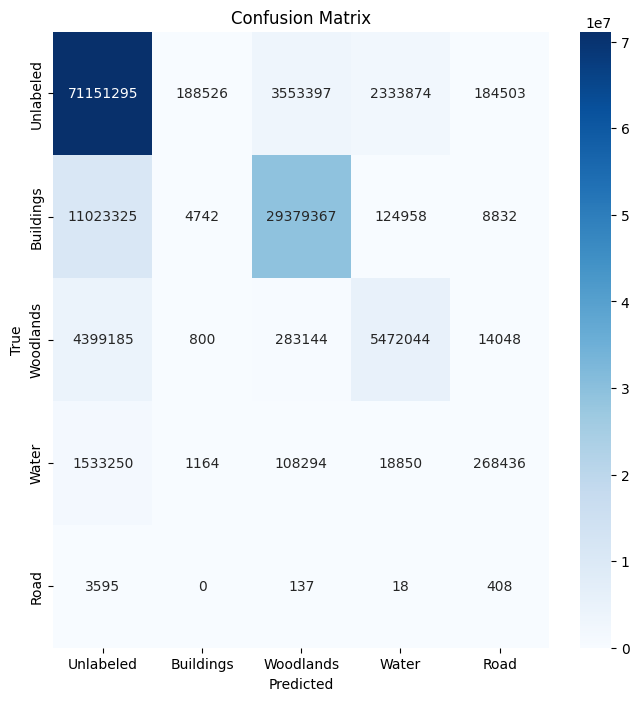

Classification Report:
              precision    recall  f1-score   support

   Unlabeled       0.81      0.92      0.86  77411595
   Buildings       0.02      0.00      0.00  40541224
   Woodlands       0.01      0.03      0.01  10169221
       Water       0.00      0.01      0.00   1929994
        Road       0.00      0.10      0.00      4158

    accuracy                           0.55 130056192
   macro avg       0.17      0.21      0.18 130056192
weighted avg       0.49      0.55      0.51 130056192



In [ ]:
num_classes = 5
input_size = (128, 128, 3)
val_sat_folder = "./../Data_resampled_128/train/sat/"
val_gt_folder = "./../Data_resampled_128/train/gt/"
model_path = "./../Model/unet_weightless_05_0.938.keras"
#model_path = "./../Model/improved_model_06_0.857.h5"
visualize_images(val_sat_folder, val_gt_folder, model_path=model_path, num_samples=5)
evaluate_model_on_folder(model_unet_noClassWeights, val_sat_folder, val_gt_folder, (128, 128))

1/1 [==============================] - 1s 707ms/step


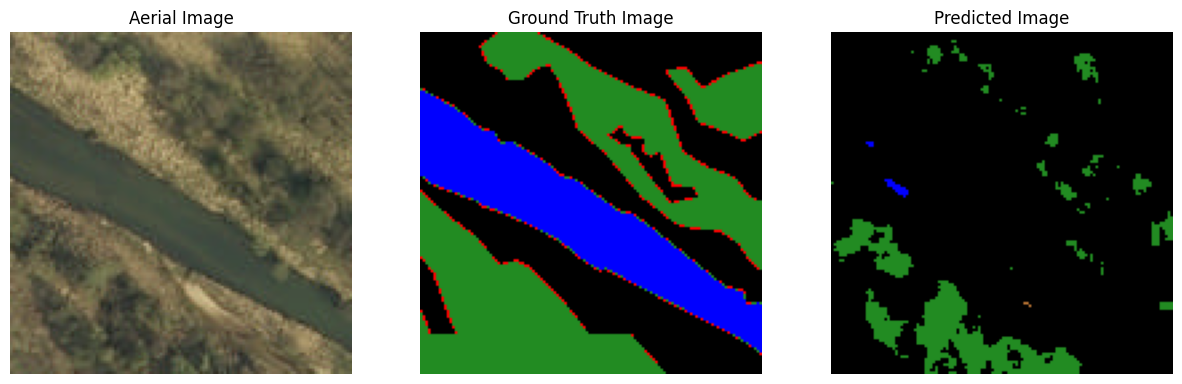

1/1 [==============================] - 0s 427ms/step


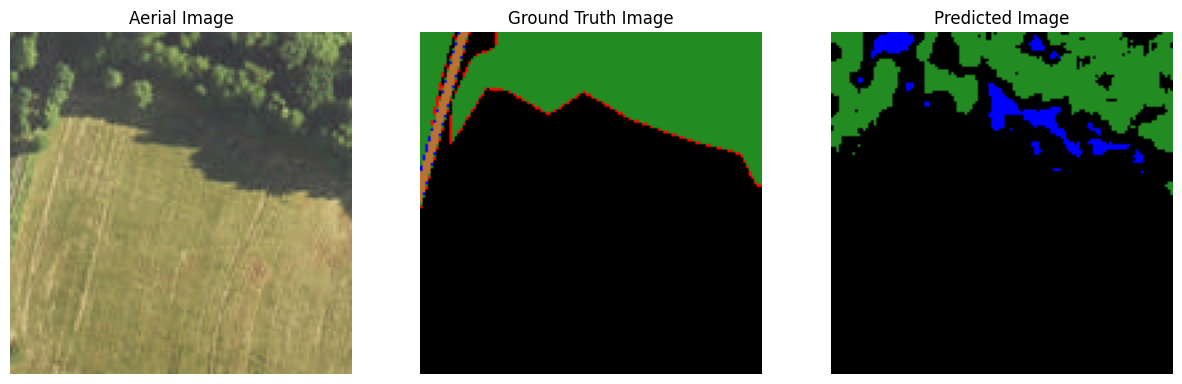

1/1 [==============================] - 0s 442ms/step


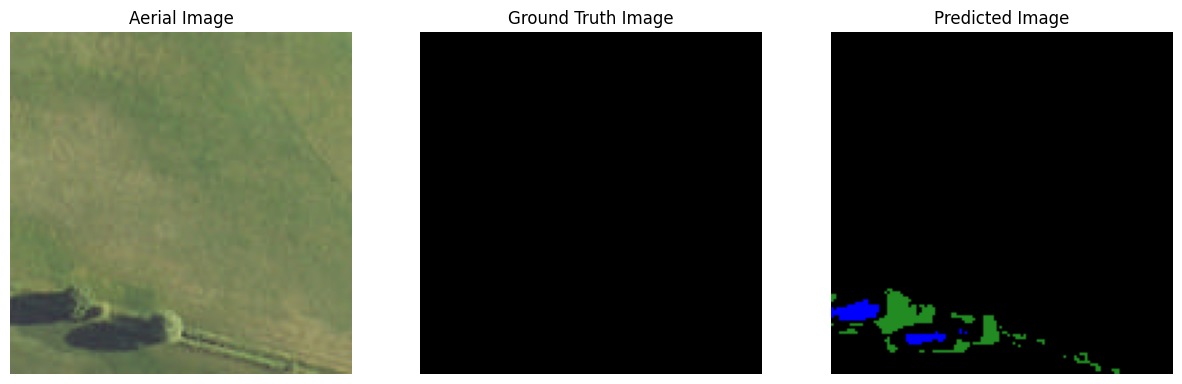

1/1 [==============================] - 0s 426ms/step


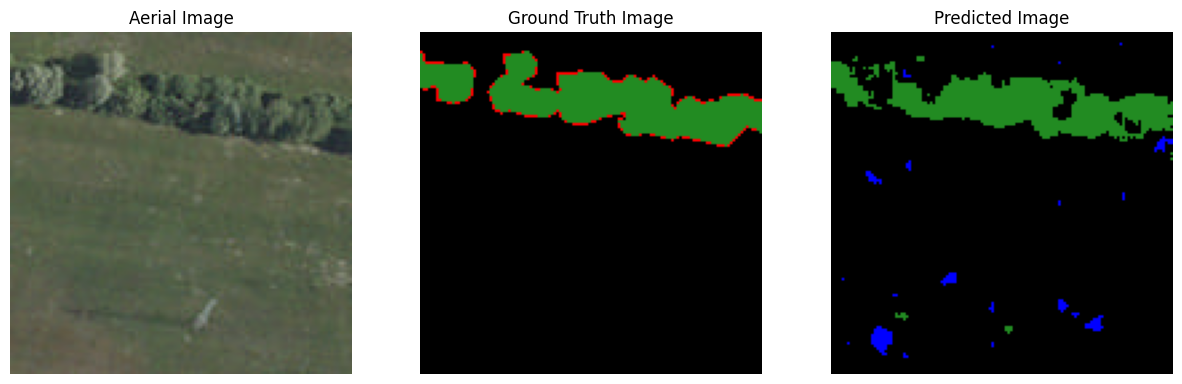

1/1 [==============================] - 0s 457ms/step


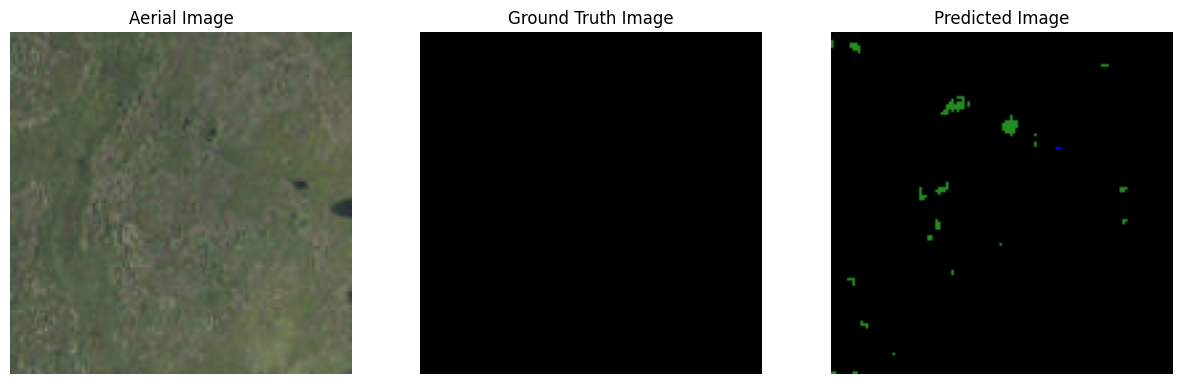

39/39 [==============================] - 125s 3s/step


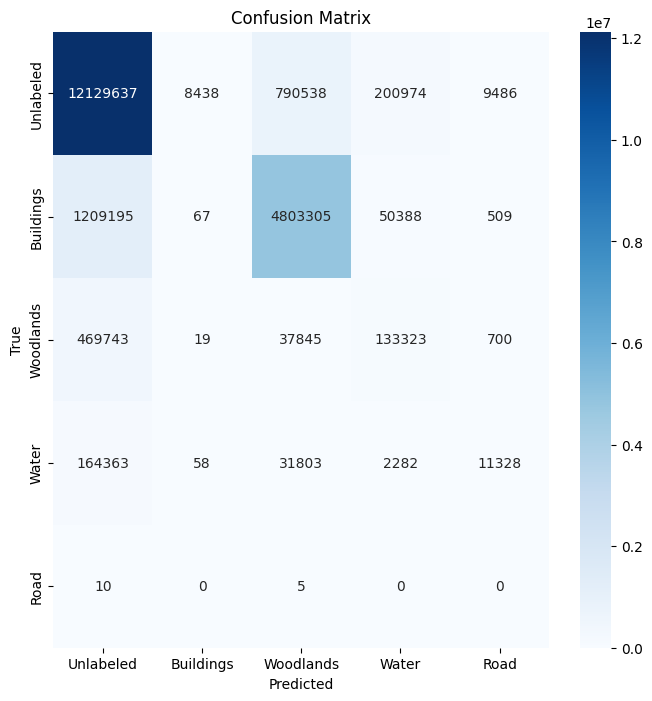

Classification Report:
              precision    recall  f1-score   support

   Unlabeled       0.87      0.92      0.89  13139073
   Buildings       0.01      0.00      0.00   6063464
   Woodlands       0.01      0.06      0.01    641630
       Water       0.01      0.01      0.01    209834
        Road       0.00      0.00      0.00        15

    accuracy                           0.61  20054016
   macro avg       0.18      0.20      0.18  20054016
weighted avg       0.57      0.61      0.59  20054016



In [ ]:
num_classes = 5
input_size = (128, 128, 3)
val_sat_folder = "./../Data_resampled_128/validate/sat/"
val_gt_folder = "./../Data_resampled_128/validate/gt/"
model_path = "./../Model/unet_weightless_05_0.938.keras"
#model_path = "./../Model/improved_model_06_0.857.h5"
model_unet_noClassWeights = keras.models.load_model(model_path)
visualize_images(val_sat_folder, val_gt_folder, model_path=model_path, num_samples=5)
evaluate_model_on_folder(model_unet_noClassWeights, val_sat_folder, val_gt_folder, (128, 128))

# Improving simple U-Net Architecture

## Improving simple U-Net Architecture - Using Class Weights

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tqdm import tqdm
from PIL import Image
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.losses import Loss
from sklearn.utils.class_weight import compute_class_weight

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from tensorflow.keras.callbacks import ModelCheckpoint

#tf.config.set_visible_devices([], 'GPU')

# Define constants
num_classes = 5
input_size = (128, 128, 3)
batch_size = 1  # You can adjust this based on your available memory
epochs = 20
train_sat_folder = "./../Data_resampled_128/train/sat/"
train_gt_folder = "./../Data_resampled_128/train/gt/"

val_sat_folder = "./../Data_resampled_128/validate/sat/"
val_gt_folder = "./../Data_resampled_128/validate/gt/"

# Function to load and preprocess the dataset
def load_data(sat_folder, gt_folder, batch_size=batch_size):
    input_images = []
    output_masks = []

    filenames = [filename for filename in os.listdir(sat_folder) if filename.endswith(".tif")]
    num_batches = len(filenames) // batch_size

    for batch_idx in tqdm(range(num_batches), desc="Loading batches", unit="batch"):
        batch_filenames = filenames[batch_idx * batch_size : (batch_idx + 1) * batch_size]
        
        batch_inputs = []
        batch_outputs = []
        for filename in batch_filenames:
            input_path = os.path.join(sat_folder, filename)
            output_path = os.path.join(gt_folder, filename.replace("sat_", "gt_"))

            # Load and preprocess input image
            input_image = np.array(Image.open(input_path)) / 255.0  # Normalize to [0, 1]
            batch_inputs.append(input_image)

            # Load and preprocess output mask
            output_mask = np.array(Image.open(output_path))

            # Ensure that class indices are within the range [0, num_classes-1]
            output_mask = np.clip(output_mask, 0, num_classes - 1)
            output_mask = keras.utils.to_categorical(output_mask, num_classes=num_classes)
            batch_outputs.append(output_mask)

        input_images.append(np.array(batch_inputs))
        output_masks.append(np.array(batch_outputs))

    return np.vstack(input_images), np.vstack(output_masks)

# Load and preprocess the training dataset
X_train, y_train = load_data(train_sat_folder, train_gt_folder)

# Load and preprocess the validation dataset
X_val, y_val = load_data(val_sat_folder, val_gt_folder)

def double_conv_block(x, n_filters):
   # Conv2D then ReLU activation
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   # Conv2D then ReLU activation
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   return x

def downsample_block(x, n_filters):
   f = double_conv_block(x, n_filters)
   p = layers.MaxPool2D(2)(f)
   p = layers.Dropout(0.3)(p)
   return f, p

def upsample_block(x, conv_features, n_filters):
   # upsample
   x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
   # concatenate
   x = layers.concatenate([x, conv_features])
   # dropout
   x = layers.Dropout(0.3)(x)
   # Conv2D twice with ReLU activation
   x = double_conv_block(x, n_filters)
   return x

# Define U-Net model for 5 classes
def unet_model(input_size=(128, 128, 3), num_classes=5):
    inputs = keras.Input(input_size)
    
    # encoder: contracting path - downsample
    # 1 - downsample
    f1, p1 = downsample_block(inputs, 64)
    # 2 - downsample
    f2, p2 = downsample_block(p1, 128)
    # 3 - downsample
    f3, p3 = downsample_block(p2, 256)
    # 4 - downsample
    f4, p4 = downsample_block(p3, 512)
    # 5 - bottleneck
    bottleneck = double_conv_block(p4, 1024)
    # decoder: expanding path - upsample
    # 6 - upsample
    u6 = upsample_block(bottleneck, f4, 512)
    # 7 - upsample
    u7 = upsample_block(u6, f3, 256)
    # 8 - upsample
    u8 = upsample_block(u7, f2, 128)
    # 9 - upsample
    u9 = upsample_block(u8, f1, 64)
    # outputs
    outputs = layers.Conv2D(num_classes, 1, padding="same", activation = "softmax")(u9)
    # unet model with Keras Functional API
    unet_model = tf.keras.Model(inputs, outputs, name="U-Net")
    return unet_model

class_weight = {0: .59, 1: .32, 2: .06, 3: .02, 4: .01}

METRICS = [
      keras.metrics.BinaryCrossentropy(name='cross entropy'),
      keras.metrics.CategoricalCrossentropy(name='cat_cross_entropy'),
      keras.metrics.MeanIoU(name='mIoU', num_classes=num_classes),
      keras.metrics.MeanSquaredError(name='Brier score'),
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

# Initialize and compile the model
model_unet_ClassWeights = unet_model(num_classes=num_classes)
model_unet_ClassWeights.compile(optimizer="adam", loss="categorical_crossentropy", metrics=METRICS)

# Define the ModelCheckpoint callback
checkpoint = ModelCheckpoint(
    'improved_model_{epoch:02d}_{val_accuracy:.3f}.keras',
    monitor='val_accuracy',  # Monitor validation accuracy
    save_best_only=True,
    save_weights_only=False,  # Save entire model
    mode='max',  # Save the model with the highest validation accuracy
    verbose=1
)

# Train the model with class weights and checkpoint callback
model_unet_history_ClassWeights = model_unet_ClassWeights.fit(X_train, y_train,
                          epochs=epochs,
                          batch_size=batch_size,
                          validation_data=(X_val, y_val),
                          class_weight=class_weight,
                          callbacks=[checkpoint]
)

Loading batches: 100%|██████████| 1224/1224 [00:03<00:00, 323.29batch/s]





Epoch 1/20

7938/7938 [==============================] - ETA: 0s - loss: 4.9572 - cross entropy: 18.3886 - cat_cross_entropy: 14.4809 - mIoU: 0.4003 - Brier score: 0.1258 - tp: 77821848.0000 - fp: 51313640.0000 - tn: 468910560.0000 - fn: 52234424.0000 - accuracy: 0.8408 - precision: 0.6026 - recall: 0.5984 - auc: 0.8747 - prc: 0.6734
Epoch 1: val_accuracy improved from -inf to 0.85714, saving model to improved_model_01_0.857.keras
7938/7938 [==============================] - 6379s 803ms/step - loss: 4.9572 - cross entropy: 18.3886 - cat_cross_entropy: 14.4809 - mIoU: 0.4003 - Brier score: 0.1258 - tp: 77821848.0000 - fp: 51313640.0000 - tn: 468910560.0000 - fn: 52234424.0000 - accuracy: 0.8408 - precision: 0.6026 - recall: 0.5984 - auc: 0.8747 - prc: 0.6734 - val_loss: 1.2558 - val_cross entropy: 0.5425 - val_cat_cross_entropy: 1.2558 - val_mIoU: 0.4000 - val_Brier score: 0.1210 - val_tp: 12891864.0000 - val_fp: 7162152.0000 - val_tn: 73053848.0000 - val_fn: 7162152.0000 - val_accur

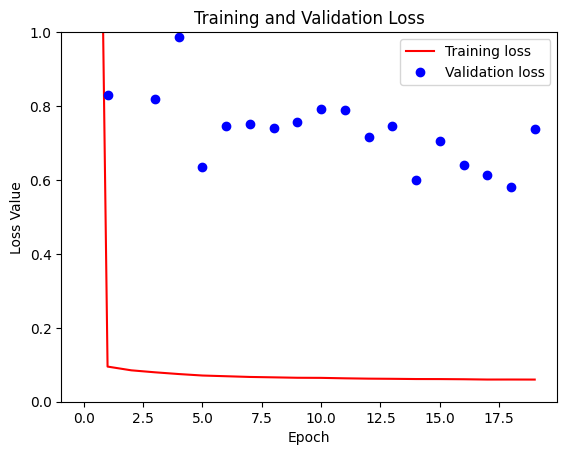

In [ ]:
import matplotlib.pyplot as plt
#model_deep_history.summary()

loss = c.history['loss']
val_loss = model_unet_history_ClassWeights.history['val_loss']

plt.figure()
plt.plot(model_unet_history_ClassWeights.epoch, loss, 'r', label='Training loss')
plt.plot(model_unet_history_ClassWeights.epoch, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

### Improving simple U-Net Architecture - Validation

1/1 [==============================] - 0s 397ms/step


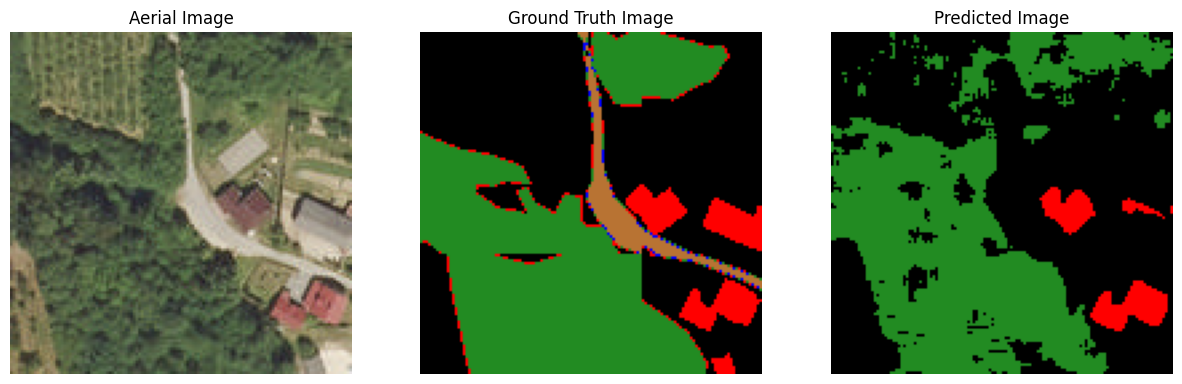

1/1 [==============================] - 1s 502ms/step


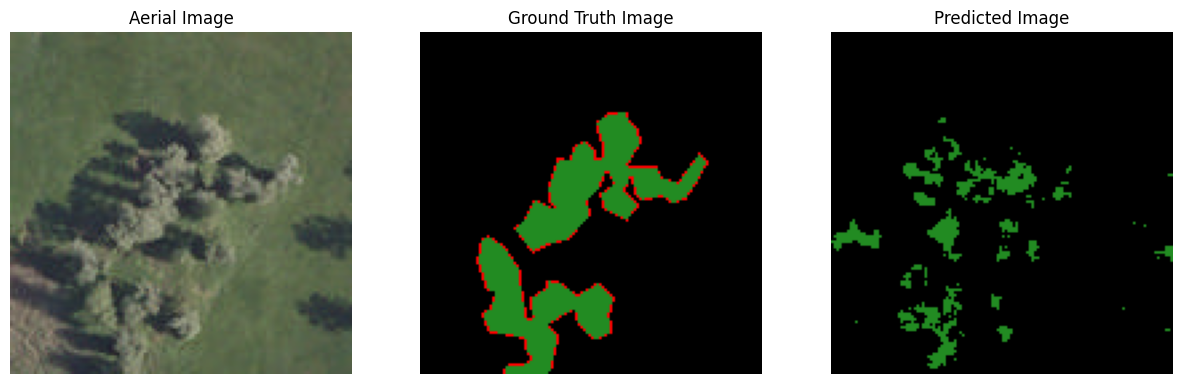

1/1 [==============================] - 0s 438ms/step


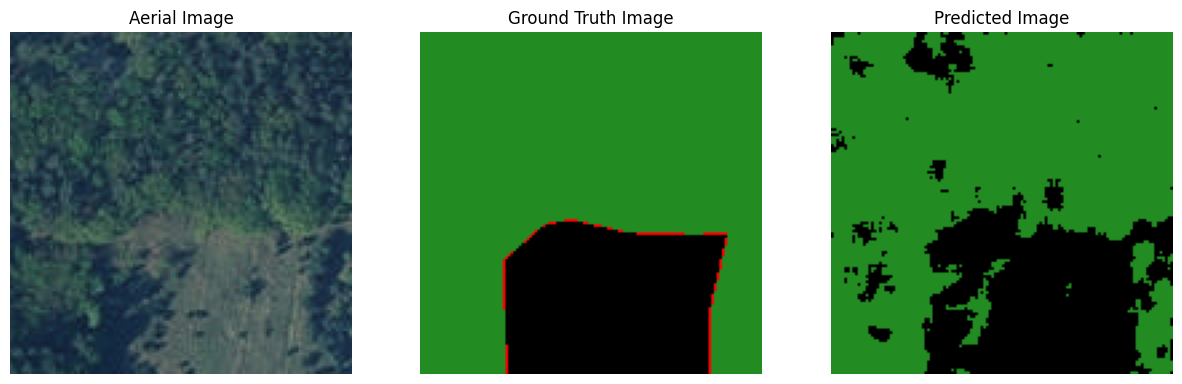

1/1 [==============================] - 0s 445ms/step


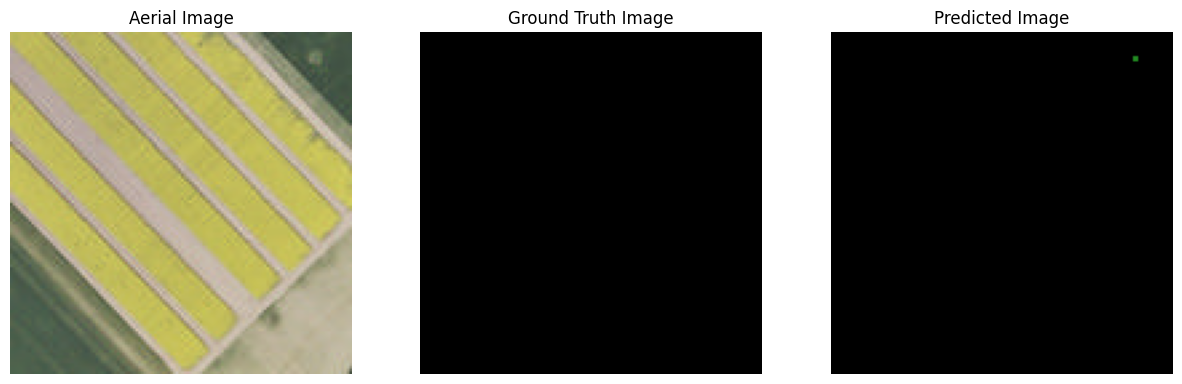

1/1 [==============================] - 0s 446ms/step


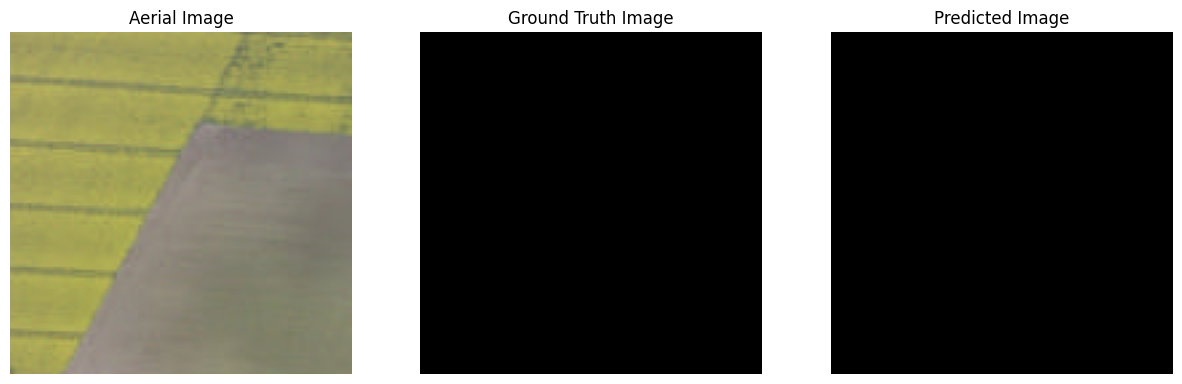

249/249 [==============================] - 865s 3s/step


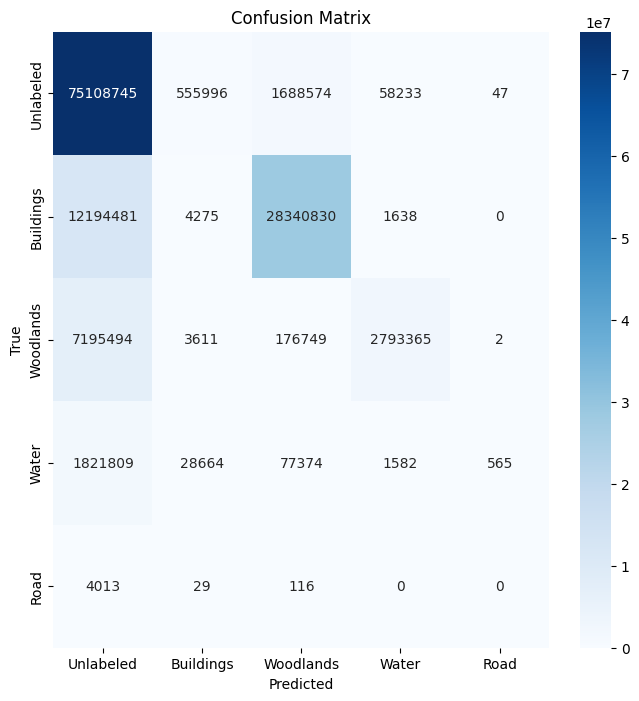

Classification Report:
              precision    recall  f1-score   support

   Unlabeled       0.78      0.97      0.86  77411595
   Buildings       0.01      0.00      0.00  40541224
   Woodlands       0.01      0.02      0.01  10169221
       Water       0.00      0.00      0.00   1929994
        Road       0.00      0.00      0.00      4158

    accuracy                           0.58 130056192
   macro avg       0.16      0.20      0.17 130056192
weighted avg       0.47      0.58      0.52 130056192



In [ ]:
num_classes = 5
input_size = (128, 128, 3)
train_sat_folder = "./../Data_resampled_128/train/sat/"
train_gt_folder = "./../Data_resampled_128/train/gt/"
model_path = "./../Model/unet_model_19_0.936.keras"
model = keras.models.load_model(model_path)
visualize_images(train_sat_folder, train_gt_folder, model_path=model_path, num_samples=5)
evaluate_model_on_folder(model, train_sat_folder, train_gt_folder, (128, 128))

1/1 [==============================] - 1s 546ms/step


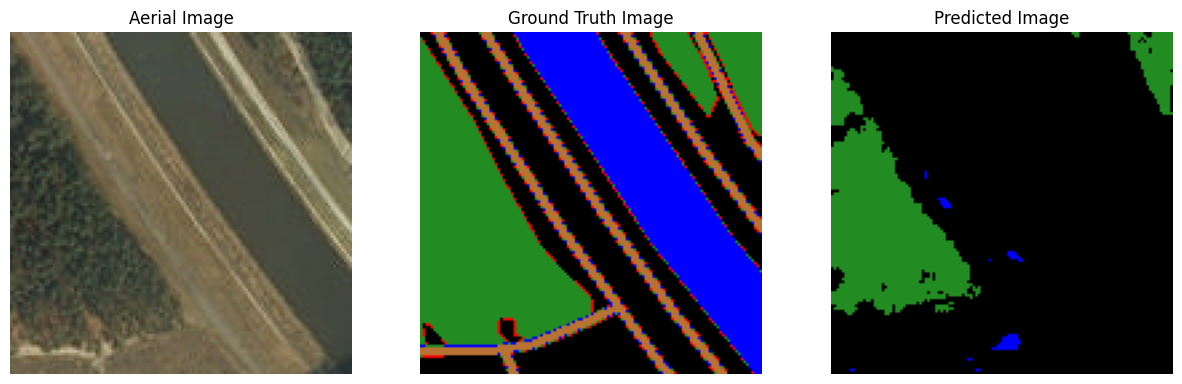

1/1 [==============================] - 1s 1s/step


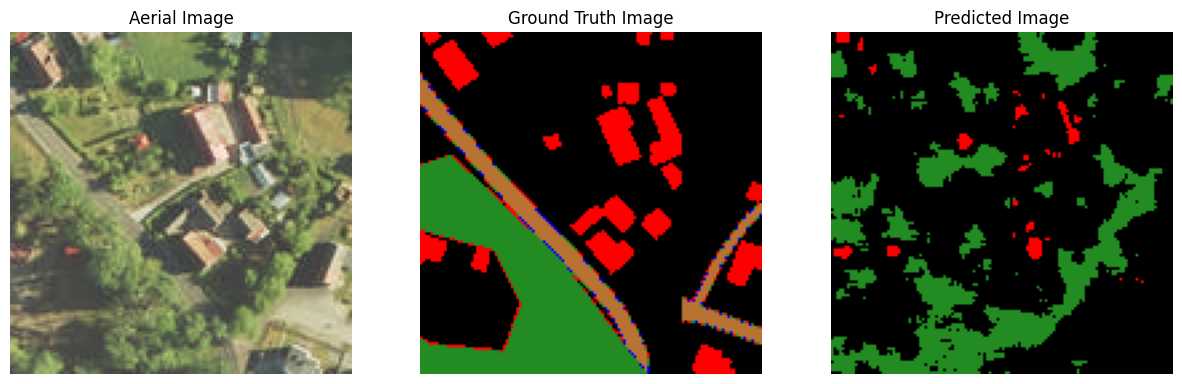

1/1 [==============================] - 0s 364ms/step


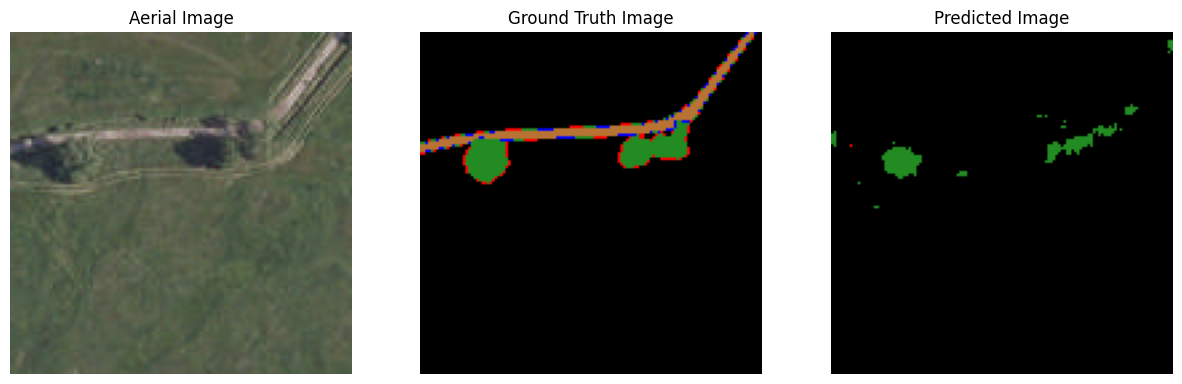

1/1 [==============================] - 0s 362ms/step


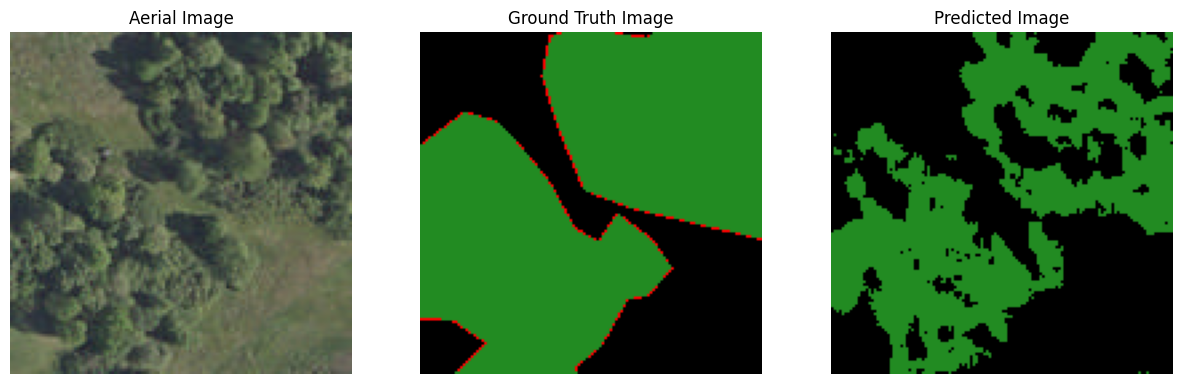

1/1 [==============================] - 0s 430ms/step


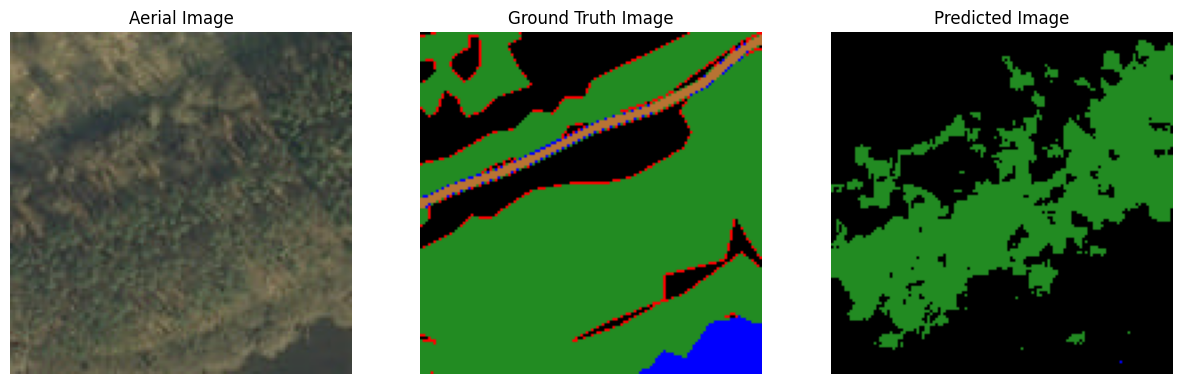

39/39 [==============================] - 132s 3s/step


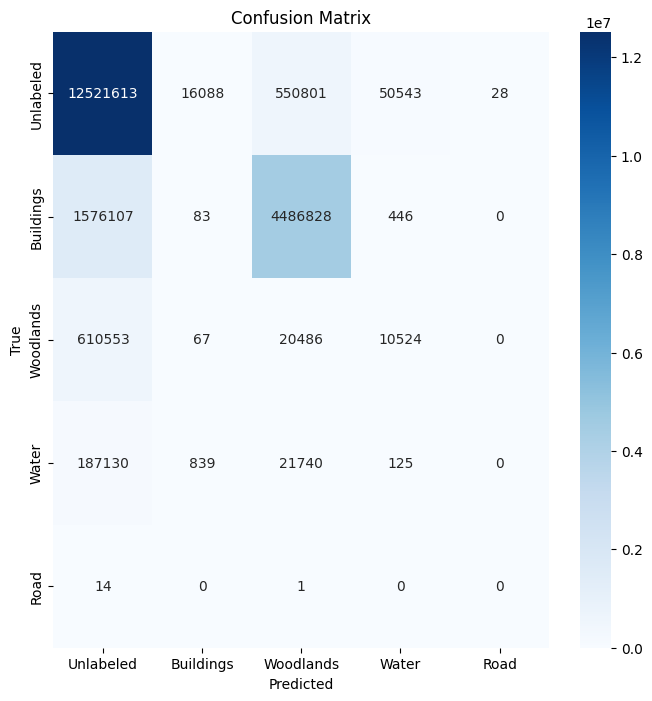

Classification Report:
              precision    recall  f1-score   support

   Unlabeled       0.84      0.95      0.89  13139073
   Buildings       0.00      0.00      0.00   6063464
   Woodlands       0.00      0.03      0.01    641630
       Water       0.00      0.00      0.00    209834
        Road       0.00      0.00      0.00        15

    accuracy                           0.63  20054016
   macro avg       0.17      0.20      0.18  20054016
weighted avg       0.55      0.63      0.59  20054016



In [ ]:
num_classes = 5
input_size = (128, 128, 3)
val_sat_folder = "./../Data_resampled_128/validate/sat/"
val_gt_folder = "./../Data_resampled_128/validate/gt/"
model_path = "./../Model/unet_model_19_0.936.keras"
model = keras.models.load_model(model_path)
#model_path = "./../Model/improved_model_06_0.857.h5"
visualize_images(val_sat_folder, val_gt_folder, model_path=model_path, num_samples=5)
evaluate_model_on_folder(model, val_sat_folder, val_gt_folder, (128, 128))

In [ ]:
# https://www.tensorflow.org/tutorials/structured_data/imbalanced_data
def plot_metrics(history):
  metrics = ['loss', 'prc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

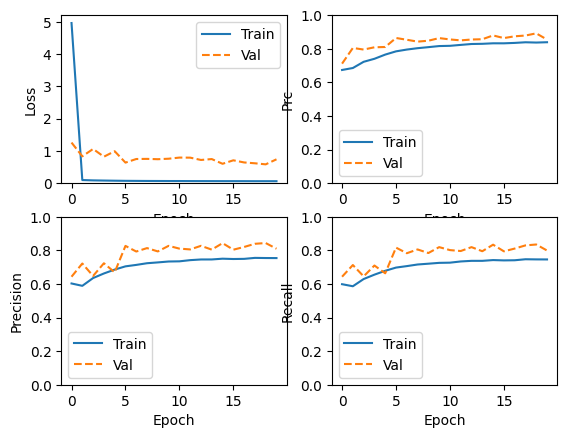

In [ ]:
plot_metrics(plot_metrics(model_unet_history_ClassWeights))